In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from scipy import signal

In [2]:
im1 = cv2.imread("Q2//Q2-1.png")
fr1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im2 = cv2.imread("Q2//Q2-2.png")
fr2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

In [5]:
def left_pseudo_inverse(A):
    A_T = A.T
    A_T_A = A_T.dot(A)
    A_T_A_inv = np.linalg.inv(A_T_A)
    A_plus = A_T_A_inv.dot(A_T)
    return A_plus

In [10]:
def lucas_kanade(img1, img2, window_size=3):
    filter_y = np.array([[-1., -1.], [1., 1.]])
    filter_x = np.array([[1., -1.], [1., -1.]])

    grad_t = img1 - img2
    # grad_x = signal.convolve2d(img1, filter_x, mode = 'same') + signal.convolve2d(img2, filter_x, mode = 'same')
    # grad_y = signal.convolve2d(img1, filter_y, mode = 'same') + signal.convolve2d(img2, filter_y, mode = 'same')
    grad_x = cv2.Sobel(img1, cv2.CV_64F, 1, 0, ksize=3) #+ cv2.Sobel(img2, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(img1, cv2.CV_64F, 0, 1, ksize=3) #+ cv2.Sobel(img2, cv2.CV_64F, 1, 0, ksize=3)
    f = np.stack([grad_x, grad_y], axis=2)

    h, w,_ = f.shape

    opt_flow = []
    for j in range(0, h - window_size + 1):
        row = []
        for i in range(0, w - window_size + 1):
            tmp = f[j:j+window_size, i:i+window_size].reshape((window_size**2, 2))
            n_t_grd = grad_t[j:j+window_size, i:i+window_size].reshape(window_size**2)
            x, residuals, rank, s = np.linalg.lstsq(tmp, n_t_grd, rcond=None)
            # print(x) #left_pseudo_inverse(tmp).dot(n_t_grd)
            row.append(x)
        opt_flow.append(np.stack(row, axis=0))

    opt_flow = np.stack(opt_flow, axis=0)#, ((1, 2), (1, 1), (0, 0))
    opt_flow = np.pad(opt_flow, ((window_size//2, window_size//2), (window_size//2, window_size//2),(0,0)), mode='constant')
    return opt_flow

In [13]:
opt_flow = lucas_kanade(fr1, fr2, 15)
opt_flow.shape

(480, 640, 2)

(480, 640)


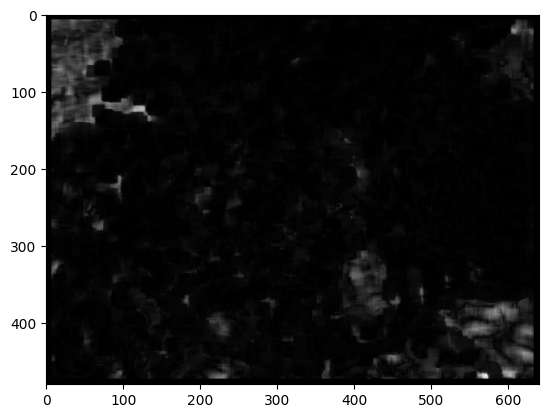

In [14]:
mask = np.stack([np.zeros_like(fr1)  for _ in range(3)], axis=2)
magnitude, angle = cv2.cartToPolar(opt_flow[:,:, 0], opt_flow[:,:, 1]) 
print(magnitude.shape)
mask[:,:, 0] = angle * 180 / np.pi / 2
mask[:,:, 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)  
rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR) 
plt.imshow(rgb)